In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from fashionmnist.utils import mnist_reader
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset as TorchDataset
import torch.nn.functional as F



normalizacija  in vizualizacija primera

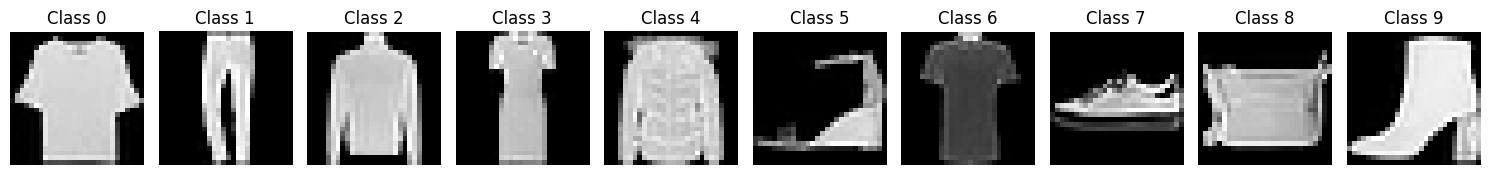

In [2]:
X, y = mnist_reader.load_mnist('fashionmnist/data/fashion', kind='train')
X = X / 255.0

# 1. Split into train/val subsets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)


classes = np.unique(y_train)
fig, axes = plt.subplots(1, 10, figsize=(15, 3))

for i, cls in enumerate(classes):
    idxs = np.where(y_train == cls)[0]
    random_idx = np.random.choice(idxs)
    axes[i].imshow(X_train[random_idx].reshape(28, 28), cmap='gray')
    axes[i].set_title(f"Class {cls}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

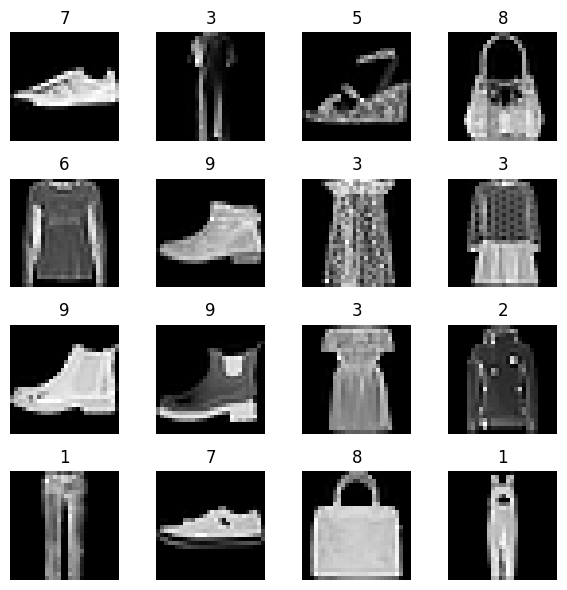

In [3]:

X_train = X_train.reshape(-1, 1, 28, 28)
X_val = X_val.reshape(-1, 1, 28, 28)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = F.one_hot(torch.tensor(y_train, dtype=torch.long), num_classes=10).float()
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = F.one_hot(torch.tensor(y_val, dtype=torch.long), num_classes=10).float()

class Dataset():
    def __init__(self, samples, labels, batch_size):
        self.samples = samples
        self.labels = labels
        self.batch_size = batch_size
        self.num_samples = samples.shape[0]
    
    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min(start_idx + self.batch_size, self.num_samples)
        return self.samples[start_idx:end_idx], self.labels[start_idx:end_idx]
    
    def __len__(self):
        return (self.num_samples + self.batch_size - 1) // self.batch_size
    
    def shuffle(self):
        perm = torch.randperm(self.num_samples)
        self.samples = self.samples[perm]
        self.labels = self.labels[perm]

train_dataset = Dataset(X_train_t, y_train_t, batch_size=64)
val_dataset = Dataset(X_val_t, y_val_t, batch_size=64)

batch_samples, batch_labels = train_dataset[0]
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(batch_samples[i, 0].numpy(), cmap='gray')
    ax.set_title(f"{torch.argmax(batch_labels[i]).item()}")
    ax.axis('off')
plt.tight_layout()
plt.show()


### Koraki

1. implementacija `Conv2d` z ročnim nanašanjem filtrov (brez oblazinjenja).
2. implementacija `MaxPool2d` z uporabo določenega jedra in koraka.
3. razred `ReLU`, ki uporablja elementno `max(x, 0)`.

In [4]:


class Conv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        # Initialize parameters
        self.weight = torch.nn.Parameter(
            torch.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.01
        )
        self.bias = torch.nn.Parameter(torch.zeros(out_channels))

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = (H - self.kernel_size) // self.stride + 1
        out_w = (W - self.kernel_size) // self.stride + 1
        out = torch.zeros((N, self.out_channels, out_h, out_w), device=x.device)
        
        for n in range(N):
            for oc in range(self.out_channels):
                for i in range(0, H - self.kernel_size + 1, self.stride):
                    for j in range(0, W - self.kernel_size + 1, self.stride):
                        region = x[n, :, i:i+self.kernel_size, j:j+self.kernel_size]
                        out[n, oc, i//self.stride, j//self.stride] = (
                            torch.sum(region * self.weight[oc]) + self.bias[oc]
                        )
        return out

class MaxPool2d(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = (H - self.kernel_size) // self.stride + 1
        out_w = (W - self.kernel_size) // self.stride + 1
        out = torch.zeros((N, C, out_h, out_w), device=x.device)
        
        for n in range(N):
            for c in range(C):
                for i in range(0, H - self.kernel_size + 1, self.stride):
                    for j in range(0, W - self.kernel_size + 1, self.stride):
                        region = x[n, c, i:i+self.kernel_size, j:j+self.kernel_size]
                        out[n, c, i//self.stride, j//self.stride] = torch.max(region)
        return out

class ReLU(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.max(x, torch.zeros_like(x))

In [5]:
in_channels = 3
out_channels = 2
kernel_size = 3
stride = 1
batch_size = 1
height, width = 5, 5

x = torch.randn(batch_size, in_channels, height, width, dtype=torch.float32)

custom_conv = Conv2d(in_channels, out_channels, kernel_size, stride)
torch.manual_seed(0)
custom_conv.weight.data = torch.randn_like(custom_conv.weight)
custom_conv.bias.data = torch.randn_like(custom_conv.bias)

torch_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride)
torch_conv.weight.data = custom_conv.weight.data.clone()
torch_conv.bias.data = custom_conv.bias.data.clone()

custom_conv_out = custom_conv(x)
torch_conv_out = torch_conv(x)
conv_diff = torch.abs(custom_conv_out - torch_conv_out).max().item()
assert conv_diff < 1e-5
print(f"Conv2d max difference: {conv_diff}")

pool_kernel = 2
pool_stride = 2
custom_pool = MaxPool2d(pool_kernel, pool_stride)
torch_pool = nn.MaxPool2d(pool_kernel, pool_stride)

custom_pool_out = custom_pool(custom_conv_out)
torch_pool_out = torch_pool(torch_conv_out)
pool_diff = torch.abs(custom_pool_out - torch_pool_out).max().item()
assert pool_diff < 1e-5
print(f"MaxPool2d max difference: {pool_diff}")

custom_relu = ReLU()
torch_relu = nn.ReLU()

custom_relu_out = custom_relu(custom_pool_out)
torch_relu_out = torch_relu(torch_pool_out)
relu_diff = torch.abs(custom_relu_out - torch_relu_out).max().item()
assert relu_diff < 1e-5
print(f"ReLU max difference: {relu_diff}")


Conv2d max difference: 1.1920928955078125e-06
MaxPool2d max difference: 9.5367431640625e-07
ReLU max difference: 9.5367431640625e-07


Rezultati so v pričakovanem območju.  lastne implementacije `Conv2d`, `MaxPool2d` in `ReLU` delujejo pravilno in se ujemajo s PyTorchovimi vgrajenimi moduli.

Max difference between MaxPool2d -> ReLU and ReLU -> MaxPool2d: 0.0


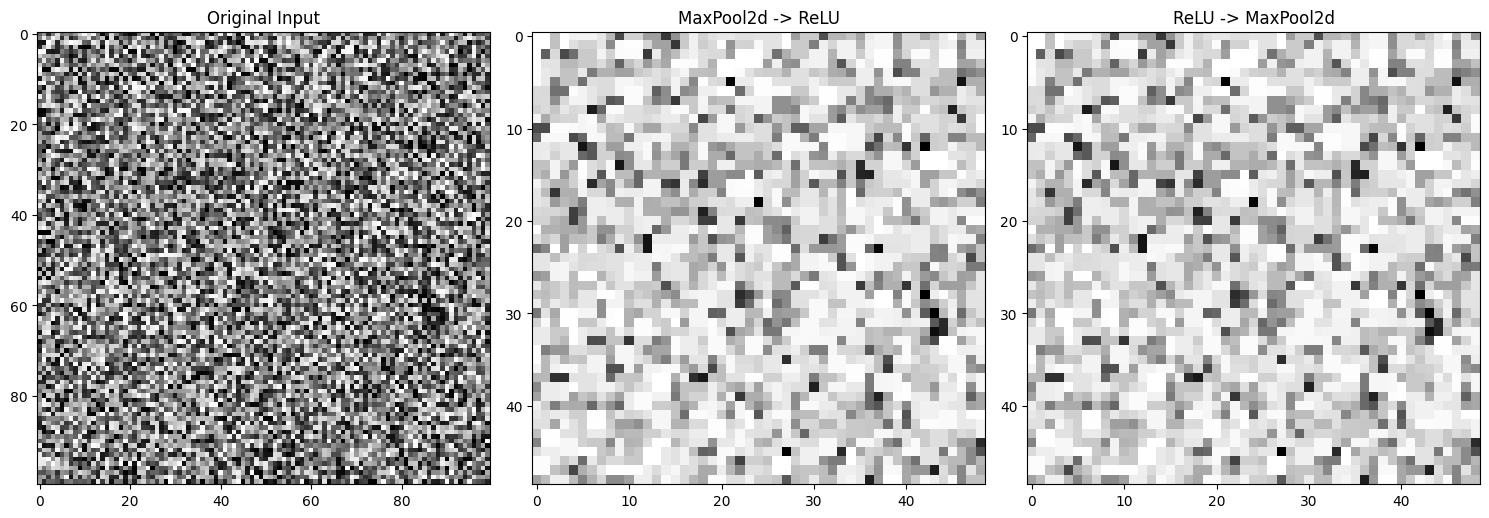

Max difference between Conv2d -> ReLU and ReLU -> Conv2d: 4.9480671882629395


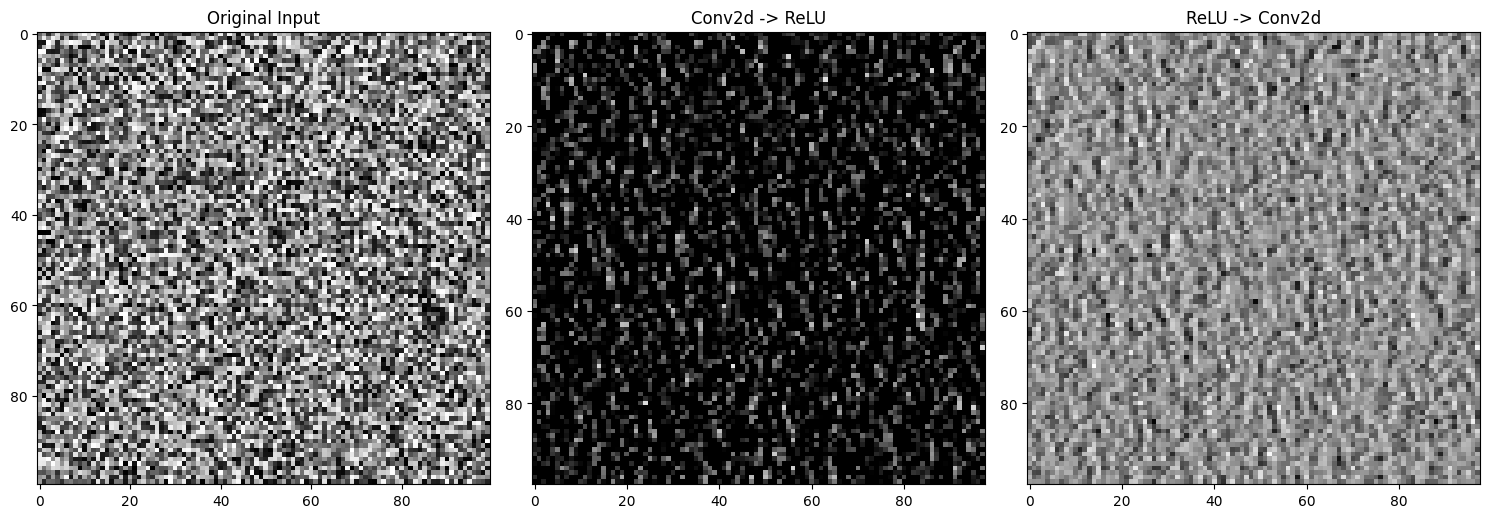

In [6]:


x = torch.rand(1, 1, 100, 100) * 2 - 1

max_pool = MaxPool2d(kernel_size=3, stride=2)
relu = ReLU()

fp1 = relu(max_pool(x))
fp2 = max_pool(relu(x))

difference = torch.abs(fp1 - fp2)
max_diff = torch.max(difference).item()
print(f"Max difference between MaxPool2d -> ReLU and ReLU -> MaxPool2d: {max_diff}")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(x[0,0].numpy(), cmap='gray')
axs[0].set_title('Original Input')
axs[1].imshow(fp1[0,0].detach().numpy(), cmap='gray')
axs[1].set_title('MaxPool2d -> ReLU')
axs[2].imshow(fp2[0,0].detach().numpy(), cmap='gray')
axs[2].set_title('ReLU -> MaxPool2d')
plt.tight_layout()
plt.show()

conv = Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1)
torch.manual_seed(0)
conv.weight.data = torch.randn_like(conv.weight)
conv.bias.data = torch.randn_like(conv.bias)

torch_conv = nn.Conv2d(1, 1, 3, stride=1)
torch_conv.weight.data = conv.weight.data.clone()
torch_conv.bias.data = conv.bias.data.clone()

fp3 = relu(conv(x))
fp4 = conv(relu(x))

difference_conv = torch.abs(fp3 - fp4)
max_diff_conv = torch.max(difference_conv).item()
print(f"Max difference between Conv2d -> ReLU and ReLU -> Conv2d: {max_diff_conv}")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(x[0,0].numpy(), cmap='gray')
axs[0].set_title('Original Input')
axs[1].imshow(fp3[0,0].detach().numpy(), cmap='gray')
axs[1].set_title('Conv2d -> ReLU')
axs[2].imshow(fp4[0,0].detach().numpy(), cmap='gray')
axs[2].set_title('ReLU -> Conv2d')
plt.tight_layout()
plt.show()

## Opazovanja

### MaxPool2d in ReLU
- **Rezultat:** Maksimalna razlika = 0.0 → **Komutativno**.
- **Razlog:** Pooling izbere maksimume, neodvisno od ReLU-jevega odstranjevanja negativnih vrednosti.

### Conv2d in ReLU
- **Rezultat:** Maksimalna razlika ≈ 4.95 → **Ni komutativno**.
- **Razlog:** ReLU spremeni vhodne podatke pred konvolucijo, kar vpliva na utežene vsote.

### Pomen
- Zaporedje je pomembno pri Conv2d in ReLU, ne pa pri MaxPool2d in ReLU.


In [7]:

class CustomNet(torch.nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        self.network = torch.nn.Sequential(
            Conv2d(1, 32, kernel_size=3, stride=1),
            MaxPool2d(kernel_size=3, stride=2),
            ReLU(),
            Conv2d(32, 64, kernel_size=3, stride=1),
            MaxPool2d(kernel_size=3, stride=2),
            ReLU(),
            Conv2d(64, 10, kernel_size=4, stride=1),
            torch.nn.Flatten()
        )
        
    def forward(self, x):
        return self.network(x)

class BuiltinNet(torch.nn.Module):
    def __init__(self):
        super(BuiltinNet, self).__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 10, kernel_size=4, stride=1),
            torch.nn.Flatten()
        )
        
    def forward(self, x):
        return self.network(x)

Max difference between CustomNet and BuiltinNet outputs: 2.421438694000244e-08


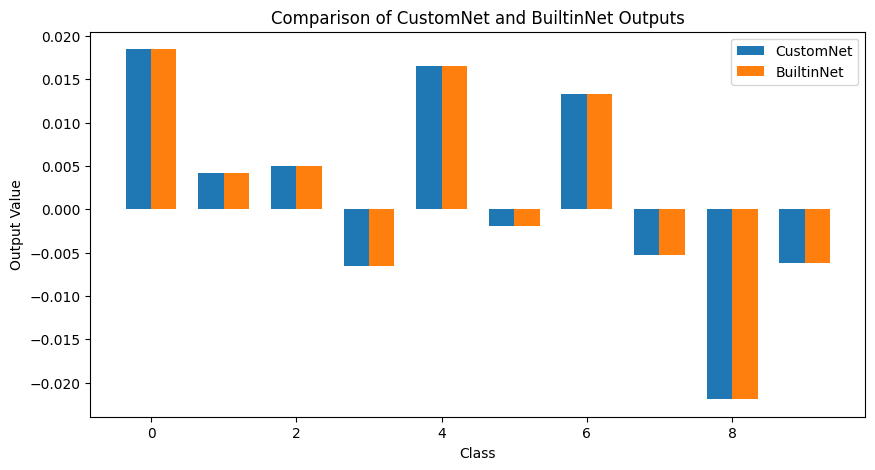

In [8]:

# Instantiate both networks
custom_net = CustomNet()
builtin_net = BuiltinNet()

# Initialize BuiltinNet with random weights for reproducibility
torch.manual_seed(0)
for name, param in builtin_net.named_parameters():
    if 'weight' in name or 'bias' in name:
        nn.init.normal_(param, mean=0.0, std=0.01)

# Copy weights and biases from BuiltinNet to CustomNet
# Assuming the layer order corresponds between CustomNet and BuiltinNet
custom_layers = [custom_net.network[0], custom_net.network[3], custom_net.network[6]]
builtin_layers = [layer for layer in builtin_net.network if isinstance(layer, nn.Conv2d)]

for c_layer, b_layer in zip(custom_layers, builtin_layers):
    c_layer.weight.data = b_layer.weight.data.clone()
    c_layer.bias.data = b_layer.bias.data.clone()

# Create a random input tensor with dimensions [B, C, H, W] = [1, 1, 25, 25]
input_tensor = torch.randn(1, 1, 25, 25)

# Pass the input through CustomNet
custom_output = custom_net(input_tensor)

# Pass the input through BuiltinNet
builtin_output = builtin_net(input_tensor)

# Calculate the pixel-wise absolute difference between the two outputs
difference = torch.abs(custom_output - builtin_output)
max_diff = torch.max(difference).item()
print(f"Max difference between CustomNet and BuiltinNet outputs: {max_diff}")

# Assert that the maximum difference is below the threshold
assert max_diff < 1e-5, f"Outputs differ by {max_diff}, which is greater than 1e-5"

# Optional: Visualize the outputs using bar charts
# Since the output is a vector of size [10], a bar chart is appropriate
custom_output_np = custom_output.detach().numpy().flatten()
builtin_output_np = builtin_output.detach().numpy().flatten()

indices = np.arange(10)
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(indices - width/2, custom_output_np, width, label='CustomNet')
plt.bar(indices + width/2, builtin_output_np, width, label='BuiltinNet')
plt.xlabel('Class')
plt.ylabel('Output Value')
plt.title('Comparison of CustomNet and BuiltinNet Outputs')
plt.legend()
plt.show()

In [9]:

class CustomDataset(TorchDataset):
    def __init__(self, samples, labels):
        self.samples = samples
        self.labels = labels
    
    def __len__(self):
        return self.samples.shape[0]
    
    def __getitem__(self, index):
        return self.samples[index], self.labels[index]
    
# Instantiate the updated datasets
train_dataset = CustomDataset(X_train_t, y_train_t)
val_dataset = CustomDataset(X_val_t, y_val_t)

# Define DataLoaders with desired batch size
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# Define the fit function
# Inspect a single batch from train_loader
for batch in train_loader:
    inputs, labels = batch
    print(f"Inputs shape: {inputs.shape}")  # Expected: [64, 1, 28, 28]
    print(f"Labels shape: {labels.shape}")  # Expected: [64, 10]
    break  # Only inspect the first batch



Inputs shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64, 10])


pravilen output

In [10]:
def fit(model, number_of_epochs, train_loader, val_loader, learning_rate=0.01):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    best_model_wts = None
    best_val_loss = float('inf')
    training_losses = []
    validation_losses = []
    
    for epoch in range(number_of_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(labels, dim=1))
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        training_losses.append(epoch_train_loss)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, torch.argmax(labels, dim=1))
                running_val_loss += loss.item() * inputs.size(0)
        
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        validation_losses.append(epoch_val_loss)
        
        print(f'Epoch {epoch+1}/{number_of_epochs} - Training Loss: {epoch_train_loss:.4f} - Validation Loss: {epoch_val_loss:.4f}')
        
        # Check if this is the best model so far
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = model.state_dict()
    
    # Load best model weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
    
    return model, training_losses, validation_losses

In [11]:


# Assuming train_dataset and val_dataset are defined as per previous exercises
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Instantiate both models
custom_net = CustomNet()
builtin_net = BuiltinNet()

# Initialize BuiltinNet weights for fair comparison
torch.manual_seed(0)
for layer in builtin_net.network:
    if isinstance(layer, nn.Conv2d):
        nn.init.normal_(layer.weight, mean=0.0, std=0.01)
        if layer.bias is not None:
            nn.init.constant_(layer.bias, 0.0)

# Copy BuiltinNet weights to CustomNet for equivalence
custom_layers = [custom_net.network[0], custom_net.network[3], custom_net.network[6]]
builtin_layers = [layer for layer in builtin_net.network if isinstance(layer, nn.Conv2d)]

for c_layer, b_layer in zip(custom_layers, builtin_layers):
    c_layer.weight.data = b_layer.weight.data.clone()
    c_layer.bias.data = b_layer.bias.data.clone()



nič  konvolucije s for z for zankami,  fold uporabit

In [ ]:
# Train CustomNet
print("Training CustomNet...")
custom_best_model, custom_train_losses, custom_val_losses = fit(custom_net, 10, train_loader, val_loader, learning_rate=0.1)



Training CustomNet...


In [ ]:
# Train BuiltinNet
print("\nTraining BuiltinNet...")
builtin_best_model, builtin_train_losses, builtin_val_losses = fit(builtin_net, 10, train_loader, val_loader, learning_rate=0.01)




Training BuiltinNet...
Epoch 1/10 - Training Loss: 0.5063 - Validation Loss: 0.5075
Epoch 2/10 - Training Loss: 0.4959 - Validation Loss: 0.5041
Epoch 3/10 - Training Loss: 0.4849 - Validation Loss: 0.4836
Epoch 4/10 - Training Loss: 0.4759 - Validation Loss: 0.4729
Epoch 5/10 - Training Loss: 0.4697 - Validation Loss: 0.4754
Epoch 6/10 - Training Loss: 0.4631 - Validation Loss: 0.4671
Epoch 7/10 - Training Loss: 0.4568 - Validation Loss: 0.4546
Epoch 8/10 - Training Loss: 0.4510 - Validation Loss: 0.4678
Epoch 9/10 - Training Loss: 0.4450 - Validation Loss: 0.4491
Epoch 10/10 - Training Loss: 0.4400 - Validation Loss: 0.4579


In [ ]:
# Plot training and validation losses
epochs = range(1, 11)
plt.figure(figsize=(12, 6))

# CustomNet Losses
plt.plot(epochs, custom_train_losses, 'b-o', label='CustomNet Training Loss')
plt.plot(epochs, custom_val_losses, 'b--o', label='CustomNet Validation Loss')

# BuiltinNet Losses
plt.plot(epochs, builtin_train_losses, 'r-s', label='BuiltinNet Training Loss')
plt.plot(epochs, builtin_val_losses, 'r--s', label='BuiltinNet Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for CustomNet and BuiltinNet')
plt.legend()
plt.grid(True)
plt.show()